# Table of Contents

1.  [Introduction](#orga7e7d6c)
2.  [Code](#org55ba15f)
    1.  [Importing Libraries](#org5acf879)
    2.  [Function for Stress Period](#orgacb95ad)
    3.  [Flopy Model](#org3259f0e)
    4.  [Simulation Outputs](#org4802e4a)
    5.  [Plots](#orge5ec85c)
3.  [Export to vtk format](#org024ef0c)
4.  [Discussions](#orgffc3c05)

<a id="orga7e7d6c"></a>

# Introduction

There are two drains in this model, and there is constant recharge that'll travel through the model to those drains and we're going to model it and see the water table and such.

<a id="org55ba15f"></a>

# Code


<a id="org5acf879"></a>

## Importing Libraries

Importing the libraries, here numpy is imported to use its functions which are really good with numbers.


In [1]:
import flopy

import numpy as np
import matplotlib.pyplot as plt

<a id="orgacb95ad"></a>

## Function for Stress Period

Let's define a function which will loop through the grids at the edge and return the grid id as well as heads at those grids for the chd package.

In [2]:
def get_chd_stress_period():
    for i in range(60):
        yield ((0, i, 0), 3820)
    for i in range(60):
        yield ((0, i, 39), 3824)

<a id="org3259f0e"></a>

## Flopy Model

Here we’ll define the working directory, model name and the executable for modflow.


In [3]:
ws = './models/2_simple_model'
name = '2_simple_model'

sim = flopy.mf6.MFSimulation(sim_name=name, sim_ws=ws, exe_name='modflow-mf6')

Let’s define the packages like in other model.

In [4]:
tdis = flopy.mf6.ModflowTdis(sim)
ims = flopy.mf6.ModflowIms(sim)
gwf = flopy.mf6.ModflowGwf(sim, modelname=name, save_flows=True)

Here in dis package we’re going to define the grid, let’s use 60x40 grid will 50m spacing in between. And 10 vertical layers. The botm parameter needs the bottom elevation of the layers, we’ll use numpy to generate a uniformly spaced intervals from it.

In [5]:
dis = flopy.mf6.ModflowGwfdis(gwf,
                              nlay=10,
                              nrow=60,
                              ncol=40,
                              delc=50,
                              delr=50,
                              top=3832,
                              botm=np.linspace(3832, 3600, 11)[1:])

For the initial head using the top elevation is a good idea, so we'll do that. `np.ones` will give us a grid filled with value of `1` and then we'll multiply with the top elevation, for the grids in the constant head boundaries we'll replace their values from the function.

In [6]:
initial_head = np.ones((10, 60, 40)) * 3832
for gp, head in get_chd_stress_period():
    initial_head[gp] = head
ic = flopy.mf6.ModflowGwfic(gwf, strt=initial_head)

Now let’s define the recharge, the value obtained here is after dividing the recharge per year by 365 as our default time unit is in days.

In [7]:
ic = flopy.mf6.ModflowGwfic(gwf)

recharge = flopy.mf6.ModflowGwfrcha(gwf, recharge=0.0055)

Now let’s define a constant hydraulic conductivity of 4.0 m/day. And the chd package will use the output from the function defined previously.

In [8]:
npf = flopy.mf6.ModflowGwfnpf(gwf,
                              k=4.0,
                              save_specific_discharge=True)
chd = flopy.mf6.ModflowGwfchd(
    gwf,
    stress_period_data=list(get_chd_stress_period()))

Now let’s define the files to save the results in.

In [9]:
budget_file = name + '.bud'
head_file = name + '.hds'
oc = flopy.mf6.ModflowGwfoc(gwf,
                            budget_filerecord=budget_file,
                            head_filerecord=head_file,
                            saverecord=[('HEAD', 'ALL'), ('BUDGET', 'ALL')])

finally writing and running the simulation.

In [10]:
sim.write_simulation()
sim.run_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing ims package ims_-1...
  writing model 2_simple_model...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package rcha_0...
    writing package npf...
    writing package chd_0...
INFORMATION: maxbound in ('gwf6', 'chd', 'dimensions') changed to 120 based on size of stress_period_data
    writing package oc...
FloPy is using the following executable to run the model: /usr/local/bin/modflow-mf6
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.2.2 07/30/2021

  MODFLOW 6 compiled Sep 19 2021 15:10:43 with GFORTRAN compiler (ver. 11.1.0)

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subjected to rigorous 
review, the USGS reserves the right to update the software as needed 
purs

(True, [])

<a id="org4802e4a"></a>

## Simulation Outputs

Since our run was successful we can extract the values we want.

In [11]:
head_arr = gwf.output.head().get_data()
bud = gwf.output.budget()

Post processing tool to get the specific discharges.

In [12]:
watertable = flopy.utils.postprocessing.get_water_table(head_arr, -1e30)
spdis = bud.get_data(text='DATA-SPDIS')[0]
qx, qy, qz = flopy.utils.postprocessing.get_specific_discharge(spdis, gwf)

<a id="orge5ec85c"></a>

## Plots

Now we can plot the results here.

/home/gaurav/.local/lib/python3.10/site-packages/flopy/plot/map.py:243: UserWarning: The following kwargs were not used by contour: 'c_label'
  contour_set = ax.tricontour(triang, plotarray, **kwargs)


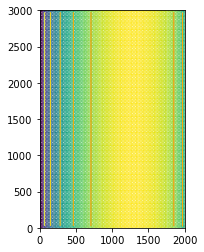

In [13]:
pmv = flopy.plot.PlotMapView(gwf)
pmv.plot_array(head_arr)
pmv.plot_grid(colors='white', linewidths=0.3)
pmv.contour_array(head_arr, linewidths=1., c_label=True, cmap='Wistia')
# flopy.plot.styles.graph_legend()
pmv.plot_vector(qx, qy, normalize=True, color="white")
plt.savefig("./images/2_plan.png")

plt.show()

The head is higher on the middle parts and the contours are aligned with Y-axis meaning the groundwater is flowing in the direction of X-axis. Since the constant head we provided was symmetrical to X-axis this makes sense.

In [14]:
def plot_x_section(**kwargs):
    fig, ax = plt.subplots(1, 1, figsize=(9, 3), constrained_layout=True)
    # first subplot
    title_text = "; ".join((f'{k}={v}' for k, v in kwargs.items()))
    ax.set_title(f"X-Section ({title_text})")
    modelmap = flopy.plot.PlotCrossSection(
        model=gwf,
        ax=ax,
        line=kwargs,
    )
    pa = modelmap.plot_array(head_arr, vmin=3600, vmax=3832)
    quadmesh = modelmap.plot_bc("CHD")
    linecollection = modelmap.plot_grid(lw=0.2, color="white")
    minor_contours = modelmap.contour_array(
        head_arr,
        levels=np.arange(3600, 3832, .1),
        linewidths=0.2,
        colors='black'
    )
    contours = modelmap.contour_array(
        head_arr,
        levels=np.arange(3600, 3832, .5),
        linewidths=0.8,
        colors='black'
    )
    ax.clabel(contours, fmt="%2.1f")
    pv = modelmap.plot_vector(qx, qy, qz,
                              headwidth=3, headlength=4, width=2e-3,
                              pivot='mid', minshaft=2, hstep=4, scale=2,
                              color='blue')

    filename = "_".join((f'{k}-{v}' for k, v in kwargs.items()))
    ax.plot(50*np.array(range(40)), watertable[20,:])
    plt.savefig(f"./images/2_section_{filename}.png")
    plt.show()

And using that function we can look at the sectional view at 20th row.



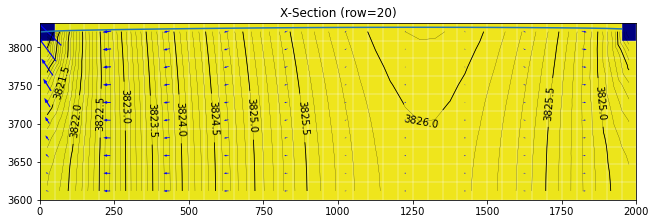

In [15]:
plot_x_section(row=20)

We can see the water flows towards the constant heads that are acting like drains, and the water table is higher on the central part.

This plot does show the vertical distribution of the head values but it’s hard to visualize the watertable in that section because it’s compressed so let’s try that on a different plot.

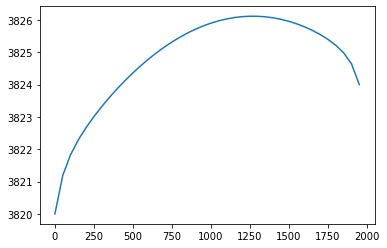

In [16]:
plt.plot(50*np.array(range(40)), watertable[20,:])
plt.savefig("./images/2_watertable_row-20.png")
plt.show()

It is exaggerated, if we make it the same range on the elevation like in that section plot we can see the variation is mild, it varies from 3820 to 3826, which is a lot if we only plot are near the surface, but not much can be seen when we plot overall plot.

 <a id="org024ef0c"></a>

# Export to vtk format

We can also export the heads data we obtained from the simulation and then visualize it using external tools like Paraview.

In [17]:
import os
from flopy.export import vtk
vtk.export_heads(sim.get_model(), os.path.join(ws, head_file), ws, smooth=False, kstpkper=[(0,0)], point_scalars=False, nanval=-1e30)

/home/gaurav/.local/lib/python3.10/site-packages/flopy/export/vtk.py:1844: UserWarning: export_heads is deprecated, use Vtk.add_heads()
  warnings.warn("export_heads is deprecated, use Vtk.add_heads()")
/home/gaurav/.local/lib/python3.10/site-packages/flopy/export/vtk.py:1847: UserWarning: nanval is deprecated, setting to np.nan
  warnings.warn("nanval is deprecated, setting to np.nan")


After running the code we get a `.vtk` file in the same directory as the model files, after that we can load it in Paraview.

<a id="orgffc3c05"></a>

# Discussions

One thing very important we can realize in this exercise is that using hard-coded numbers everywhere makes it hard to change grid sizes since we also have to modify it everywhere, so from next exercises we'll be defining some utility functions and simulation parameters, and using them for the overall script, so we only have to modify them at the beginning, and we can change any aspect of the simulation easily.
